<a href="https://colab.research.google.com/github/noriakihanya/text2animation/blob/main/rq_vae_transformer_demo_nh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

論文  
https://arxiv.org/abs/2203.01941<br>
<br> 

## 環境セットアップ

## GPU確認

In [ ]:
!nvidia-smi

## GitHubからコード取得

In [ ]:
%cd /content

!git clone https://github.com/kakaobrain/rq-vae-transformer.git

In [3]:
#@title Workspace作成
import os

workspace_rq = "/content/Workspace/rq_vae"
os.makedirs(workspace_rq, exist_ok=True)


## ライブラリのインストール

In [ ]:
%cd /content/rq-vae-transformer

# もし RESTART RUNTIMEが表示されたら「ランタイム」→「ランタイムを再起動」
!pip install -r requirements.txt
!pip install git+https://github.com/alainrouillon/py-googletrans@feature/enhance-use-of-direct-api

## ライブラリのインポート

In [ ]:
%cd /content/rq-vae-transformer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import yaml
import torch
import torchvision
import clip
import torch.nn.functional as F

from notebooks.notebook_utils import TextEncoder, load_model, get_generated_images_by_texts


## 学習済みモデルのセットアップ

In [ ]:
%cd /content/rq-vae-transformer
!mkdir pretrained
%cd pretrained

!wget https://arena.kakaocdn.net/brainrepo/models/RQVAE/dcd95e8f08408e113aab6451fae895f5/cc3m.tar.gz
!tar -xvf cc3m.tar.gz

## モデルのロード

In [ ]:
vqvae_path = '/content/rq-vae-transformer/pretrained/cc3m/stage1/model.pt'
model_path = '/content/rq-vae-transformer/pretrained/cc3m/stage2/model.pt'

# load stage 1 model: RQ-VAE
model_vqvae, _ = load_model(vqvae_path)

# load stage 2 model: RQ-Transformer
model_ar, config = load_model(model_path, ema=False)

# GPUにセット
model_ar = model_ar.cuda().eval()
model_vqvae = model_vqvae.cuda().eval()

# CLIPモデルのダウンロード
model_clip, preprocess_clip = clip.load("ViT-B/32", device='cpu')
model_clip = model_clip.cuda().eval()

# prepare text encoder to tokenize natual languages
text_encoder = TextEncoder(tokenizer_name=config.dataset.txt_tok_name, 
                           context_length=config.dataset.context_length)

# Text to Image

In [17]:
#@markdown 入力テキストを設定してください。

generating_img = "自転車に乗る長靴を履いた猫の写真"

In [18]:
#@title 英訳 

from googletrans import Translator
tr = Translator(service_urls=['translate.googleapis.com'])

try:
  text = tr.translate(generating_img, dest="en").text
except Exception as e:
  tr = Translator(service_urls=['translate.googleapis.com'])

print("generating_img : ",text)

generating_img :  Photo of a cat in boots riding a bicycle


In [20]:
#@markdown スタイルを選択してください。

art_style = 'in Ghibli style' #@param [' in vray unreal engine hyperrealistic', ' in Ghibli style', ' in Raphael style', ' in banksy style', ' in Makoto Shinkai style','your choice!']

#@markdown ”your choice!”を選択した場合には以下に任意のスタイルを英語で入力
if art_style == 'your choice!':
    your_style = "" #@param {type:"string"}
    art_style = your_style


text_prompts_list = ["'",text," ",art_style,"'"]
tmp_text_prompts = "".join(text_prompts_list)

text_prompts = tmp_text_prompts

num_samples = 16
temperature= 1.0
top_k=1024
top_p=0.95

In [ ]:
pixels = get_generated_images_by_texts(model_ar,
                                       model_vqvae,
                                       text_encoder,
                                       model_clip,
                                       preprocess_clip,
                                       text_prompts,
                                       num_samples,
                                       temperature,
                                       top_k,
                                       top_p,
                                      )

## 結果の表示

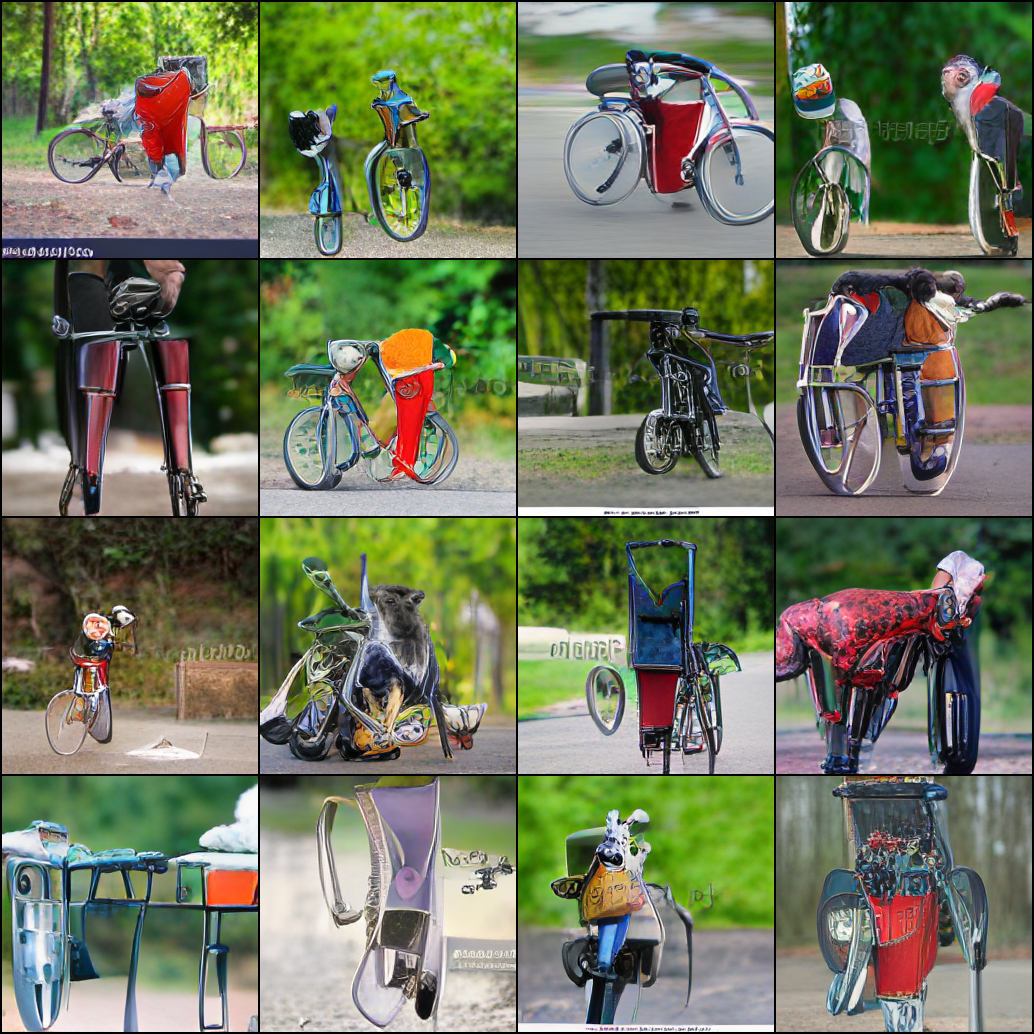

In [22]:
num_visualize_samples = 16
images = [pixel.cpu().numpy() * 0.5 + 0.5 for pixel in pixels]
images = torch.from_numpy(np.array(images[:num_visualize_samples]))
images = torch.clamp(images, 0, 1)
grid = torchvision.utils.make_grid(images, nrow=4)

img = Image.fromarray(np.uint8(grid.numpy().transpose([1,2,0])*255))
display(img)